In [1]:
import torch
import json
import numpy as np

In [4]:
base_path = "/net/scratch/zsarwar/exps/GPT_experts-8-topk-1-layers1-heads-12-base-moe/435ca0f0132375cf6f6dccff307b6d39/tensorboard/k001_1626132.1747956097207773171.pt.trace.json"
lora_path = "/net/scratch/zsarwar/exps/GPT_experts-8-topk-1-layers1-heads-12-lora/73ccb3e32913c465b8d79c5b48a590ca/tensorboard/k001_1625069.1747956142688104721.pt.trace.json"



In [5]:
# Target fully-qualified function name (from the 'name' field)
targets = ["megatron/model/moe_base.py(253): forward", "nn.Module: TopKTokenChoiceRouter_0", "megatron/model/moe_base.py(73): indices_and_bins", "megatron/model/moe_base.py(96): permute_and_compute",
           "megatron/mpu/mappings.py(317): copy_to_model_parallel_region", "megablocks/ops/gather.py(14): forward", "megatron/mpu/mappings.py(337): gather_from_expert_model_parallel_region", 
            "megablocks/ops/scatter.py(64): scatter", "megatron/mpu/initialize.py(300): get_expert_token_counts_for_rank", "nn.Module: ParallelGroupedMLP_0" ]



In [7]:
base = {
    "Expert Router": 0.591,
    "Indexing": 0.453,
    "Data Movement": (10.479 - (0.301 + 0.216)),
    "GroupedGemm Experts": 0.301 + 0.216,

}


lora = {
    "Expert Router": 0.527,
    "LoRE Routers": 0.412,
    "Indexing": 0.394,
    "Data Movement": (19.856  - (0.247 + 0.254 + 6.362)),
    "GroupedGemm Experts": 0.247 + 0.254,
    "GroupedGemm LoREs": 6.362,
}

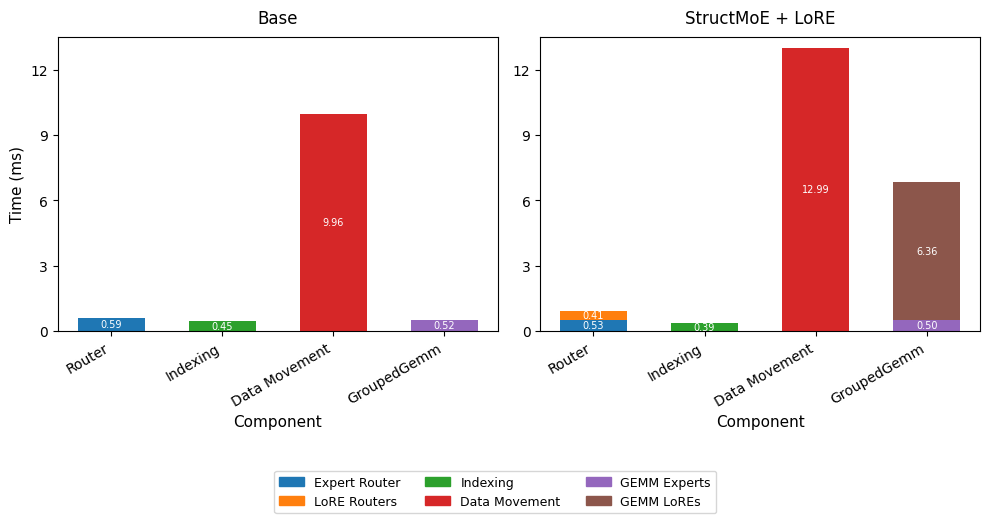

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Raw data
base_raw = {
    "Expert Router": 0.591,
    "LoRE Routers": 0.0,
    "Indexing": 0.453,
    "Data Movement": 10.479 - (0.301 + 0.216),
    "GroupedGemm Experts": 0.301 + 0.216,
    "GroupedGemm LoREs": 0.0,
}
lora_raw = {
    "Expert Router": 0.527,
    "LoRE Routers": 0.412,
    "Indexing": 0.394,
    "Data Movement": 19.856 - (0.247 + 0.254 + 6.362),
    "GroupedGemm Experts": 0.247 + 0.254,
    "GroupedGemm LoREs": 6.362,
}

# Category order
categories = ["Router", "Indexing", "Data Movement", "GroupedGemm"]
x = np.arange(len(categories))
width = 0.6

# Segment breakdown for stacking
def build_segments(raw):
    return {
        "Router": [("Expert Router", raw["Expert Router"]), ("LoRE Routers", raw["LoRE Routers"])],
        "Indexing": [("Indexing", raw["Indexing"])],
        "Data Movement": [("Data Movement", raw["Data Movement"])],
        "GroupedGemm": [("GEMM Experts", raw["GroupedGemm Experts"]), ("GEMM LoREs", raw["GroupedGemm LoREs"])],
    }

base_segs = build_segments(base_raw)
lora_segs = build_segments(lora_raw)

# A nicer color palette
palette = plt.get_cmap("tab10")
segment_colors = {
    "Expert Router":     palette(0),
    "LoRE Routers":      palette(1),
    "Indexing":          palette(2),
    "Data Movement":     palette(3),
    "GEMM Experts":      palette(4),
    "GEMM LoREs":        palette(5),
}

def plot_timing(fig_size=(8,4), y_limit=None, y_pad=0.1):
    """
    Plots two side-by-side stacked bar charts with customizable size and y-axis,
    including on-bar numeric annotations.
    """
    fig, axes = plt.subplots(1, 2, figsize=fig_size, sharey=True)
    # compute max heights for autoscaling if needed
    max_base = sum(base_raw.values())
    max_lora = sum(lora_raw.values())
    default_ymax = max(max_base, max_lora) * (1 + y_pad)

    for ax, segs, title in zip(axes, (base_segs, lora_segs), ("Base", "StructMoE + LoRE")):
        ax.set_title(title, fontsize=12, pad=10)
        bottom = np.zeros_like(x, dtype=float)
        for label, color in segment_colors.items():
            heights = [ next((h for l, h in segs[cat] if l==label), 0) for cat in categories ]
            bars = ax.bar(x, heights, width, bottom=bottom, color=color, edgecolor='none')
            # Annotate each bar segment
            for bar, h in zip(bars, heights):
                if h > 0:
                    ax.text(
                        bar.get_x() + bar.get_width()/2,
                        bar.get_y() + h/2,
                        f"{h:.2f}",
                        ha='center', va='center',
                        fontsize=7,
                        color='white'
                    )
            bottom += heights

        ax.set_xticks(x)
        ax.set_xticklabels(categories, rotation=30, ha='right', fontsize=10)
        ax.set_xlabel("Component", fontsize=11)
        # restore y‐axis tick labels
        ax.tick_params(axis='y', which='major', labelleft=True)
        ax.yaxis.set_major_locator(plt.MaxNLocator(5))

        if y_limit:
            ax.set_ylim(y_limit)
        else:
            ax.set_ylim(0, default_ymax)

    axes[0].set_ylabel("Time (ms)", fontsize=11)
    # shared legend below
    handles = [plt.Rectangle((0,0),1,1, color=segment_colors[l]) for l in segment_colors]
    fig.legend(handles, list(segment_colors.keys()), ncol=3, fontsize=9,
               loc="lower center", bbox_to_anchor=(0.5, -0.15))
    plt.tight_layout(rect=[0,0,1,0.9])
    plt.show()

# Example usage:
plot_timing(fig_size=(10,5), y_limit=(0,13.5))

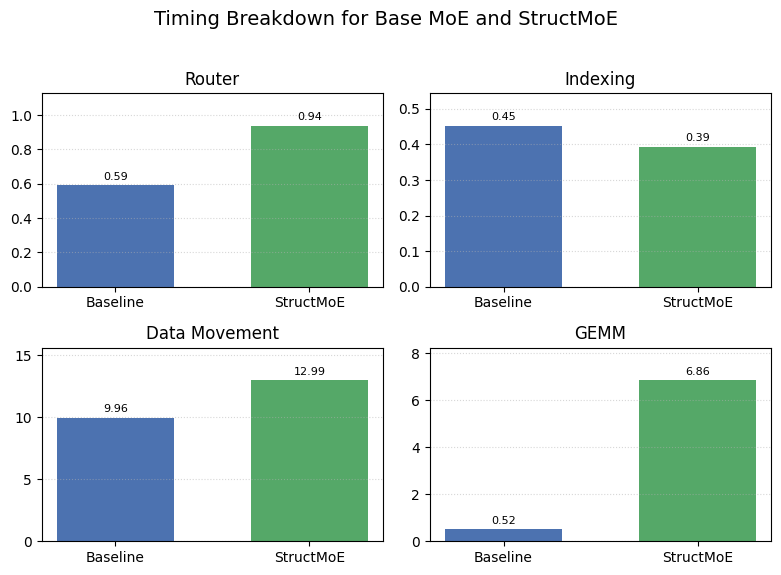

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Raw breakdowns
base_vals = {
    "Router":         0.591,
    "Indexing":       0.453,
    "Data Movement":  10.479 - (0.301 + 0.216),
    "GEMM":           0.301 + 0.216,
}
lora_vals = {
    "Router":         0.527 + 0.412,            # Expert Router + LoRE Routers
    "Indexing":       0.394,
    "Data Movement":  19.856 - (0.247 + 0.254 + 6.362),
    "GEMM":           0.247 + 0.254 + 6.362,    # Experts + LoREs
}

components = ["Router", "Indexing", "Data Movement", "GEMM"]
n = len(components)
cols = 2
rows = (n + 1)//cols

# Colors
base_color = "#4C72B0"
lora_color = "#55A868"

fig, axs = plt.subplots(rows, cols, figsize=(8, 6))
axs = axs.flatten()

for ax, comp in zip(axs, components):
    x = np.arange(2)
    vals = [base_vals[comp], lora_vals[comp]]
    bars = ax.bar(x, vals, color=[base_color, lora_color], width=0.6)
    ax.set_xticks(x)
    ax.set_xticklabels(["Baseline", "StructMoE"], fontsize=10)
    ax.set_title(comp, fontsize=12)
    ax.grid(axis="y", linestyle=":", alpha=0.5)
    # annotate
    ymax = max(vals)
    for b in bars:
        h = b.get_height()
        ax.text(b.get_x() + b.get_width()/2,
                h + 0.02*ymax,
                f"{h:.2f}",
                ha="center", va="bottom", fontsize=8)
    # set y-limit individually
    ax.set_ylim(0, ymax * 1.2)

# hide any extra axes
for ax in axs[n:]:
    ax.axis("off")

fig.suptitle("Timing Breakdown for Base MoE and StructMoE", fontsize=14, y=0.95)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.savefig("Timing_breakdown.pdf", bbox_inches='tight')
plt.show()

In [18]:

with open(base_path) as f:
    trace_data = json.load(f)

events = trace_data["traceEvents"]

# Target fully-qualified function name (from the 'name' field)

targets = ["megatron/model/moe_base.py(253): forward", "nn.Module: TopKTokenChoiceRouter_0", "megatron/model/moe_base.py(73): indices_and_bins", "megatron/model/moe_base.py(96): permute_and_compute",
           "megatron/mpu/mappings.py(317): copy_to_model_parallel_region", "megablocks/ops/gather.py(14): forward", "megatron/mpu/mappings.py(337): gather_from_expert_model_parallel_region", 
            "megablocks/ops/scatter.py(64): scatter", "megatron/mpu/initialize.py(300): get_expert_token_counts_for_rank", "nn.Module: ParallelGroupedMLP_0" ]

# Total time in microseconds
for target in targets:
    total_us = sum(
        e["dur"] for e in events
        if e.get("ph") == "X" and e.get("name") == target
    )

    # Convert to milliseconds
    total_ms = total_us / 1000

    print(f"Total time in {target}: {total_ms:.2f} ms")


    # target = "megatron/model/moe_base.py(253): forward"
    # matches = [e for e in events if e.get("ph") == "X" and e.get("name") == target]

    # print(f"Total entries: {len(matches)}")
    # for i, e in enumerate(matches):
    #     print(f"{i:02d}: start={e['ts']:.0f} µs, dur={e['dur']:.1f} µs")







Total time in megatron/model/moe_base.py(253): forward: 47.45 ms
Total time in nn.Module: TopKTokenChoiceRouter_0: 2.44 ms
Total time in megatron/model/moe_base.py(73): indices_and_bins: 1.83 ms
Total time in megatron/model/moe_base.py(96): permute_and_compute: 42.78 ms
Total time in megatron/mpu/mappings.py(317): copy_to_model_parallel_region: 0.26 ms
Total time in megablocks/ops/gather.py(14): forward: 0.99 ms
Total time in megatron/mpu/mappings.py(337): gather_from_expert_model_parallel_region: 0.19 ms
Total time in megablocks/ops/scatter.py(64): scatter: 0.88 ms
Total time in megatron/mpu/initialize.py(300): get_expert_token_counts_for_rank: 0.13 ms
Total time in nn.Module: ParallelGroupedMLP_0: 2.48 ms


In [19]:

with open(lora_path) as f:
    trace_data = json.load(f)

events = trace_data["traceEvents"]

# Target fully-qualified function name (from the 'name' field)

targets = ["megatron/model/moe_lora.py(257): forward", "nn.Module: TopKTokenChoiceRouter_0", "megatron/model/moe_lora.py(69): indices_and_bins", "megatron/model/moe_lora.py(92): permute_and_compute",
           "megatron/mpu/mappings.py(317): copy_to_model_parallel_region", "megablocks/ops/gather.py(14): forward", "megatron/mpu/mappings.py(337): gather_from_expert_model_parallel_region", 
            "megablocks/ops/scatter.py(64): scatter", "megatron/mpu/initialize.py(300): get_expert_token_counts_for_rank", "nn.Module: TopKTokenChoiceRouterLoRa_0", "nn.Module: ParallelGroupedLoRas_0", "nn.Module: ParallelGroupedMLP_0" ]

# Total time in microseconds
for target in targets:
    total_us = sum(
        e["dur"] for e in events
        if e.get("ph") == "X" and e.get("name") == target
    )

    # Convert to milliseconds
    total_ms = total_us / 1000

    print(f"Total time in {target}: {total_ms:.2f} ms")


    # target = "megatron/model/moe_base.py(253): forward"
    # matches = [e for e in events if e.get("ph") == "X" and e.get("name") == target]

    # print(f"Total entries: {len(matches)}")
    # for i, e in enumerate(matches):
    #     print(f"{i:02d}: start={e['ts']:.0f} µs, dur={e['dur']:.1f} µs")







Total time in megatron/model/moe_lora.py(257): forward: 77.78 ms
Total time in nn.Module: TopKTokenChoiceRouter_0: 2.06 ms
Total time in megatron/model/moe_lora.py(69): indices_and_bins: 1.54 ms
Total time in megatron/model/moe_lora.py(92): permute_and_compute: 73.78 ms
Total time in megatron/mpu/mappings.py(317): copy_to_model_parallel_region: 0.22 ms
Total time in megablocks/ops/gather.py(14): forward: 1.45 ms
Total time in megatron/mpu/mappings.py(337): gather_from_expert_model_parallel_region: 0.37 ms
Total time in megablocks/ops/scatter.py(64): scatter: 1.81 ms
Total time in megatron/mpu/initialize.py(300): get_expert_token_counts_for_rank: 0.25 ms
Total time in nn.Module: TopKTokenChoiceRouterLoRa_0: 1.50 ms
Total time in nn.Module: ParallelGroupedLoRas_0: 19.60 ms
Total time in nn.Module: ParallelGroupedMLP_0: 32.51 ms


Total time in megatron/model/moe_lora.py(257): forward: 0.00 ms
Total time in nn.Module: ParallelGroupedLoRas_0: 0.00 ms
Total time in nn.Module: TopKTokenChoiceRouterLoRa_0: 0.00 ms
Total time in nn.Module: TopKTokenChoiceRouter_0: 2.44 ms
Total time in megatron/model/moe_lora.py(73): indices_and_bins: 0.00 ms
Total time in megatron/model/moe_lora.py(92): permute_and_compute: 0.00 ms
Total time in nn.Module: ParallelGroupedMLP_0: 2.48 ms
Total time in megatron/mpu/mappings.py(321): copy_to_model_parallel_region: 0.00 ms
Total time in get_expert_token_counts_for_rank: 0.00 ms
Total time in megablocks/ops/gather.py(14): forward: 0.99 ms
Total time in megablocks/ops/scatter.py(64): scatter: 0.88 ms
Total time in gather_from_expert_model_parallel_region: 0.00 ms


In [ ]:
# op_names = sorted(set(e["name"] for e in events if e.get("ph") == "X"))
# print("All op names:")
# for name in op_names:
#     print(name)



All file paths:


{}